In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt


import random 
import math

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [2]:
# Data Pre-processing- splitting the dataset into test/train set 

csv_data = pd.read_csv('input/barrier_fluegas_final2.csv')
csv_data.info()

train_X, test_X, train_y, test_y = train_test_split(csv_data.Canonical_STRONG_radius, csv_data.barrier_N2, test_size = 0.25, random_state = 42)
train_X, train_y = train_X.reset_index(drop=True), train_y.reset_index(drop=True)
test_X, test_y = test_X.reset_index(drop=True), test_y.reset_index(drop=True)

print(train_X[1])
print(train_y[1])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24884 entries, 0 to 24883
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   pore_number              24884 non-null  int64  
 1   N                        24884 non-null  int64  
 2   Canonical_STRONGs        24884 non-null  object 
 3   radius                   24884 non-null  float64
 4   Canonical_STRONG_radius  24884 non-null  object 
 5   barrier_CO2              24884 non-null  float64
 6   barrier_N2               24884 non-null  float64
 7   barrier_O2               24884 non-null  float64
dtypes: float64(4), int64(2), object(2)
memory usage: 1.5+ MB
225AAFFFZFFAAFFZFFAAFFZFFFZFACAFFFZFFZF
1.89


In [3]:
# Block - Data pre-processing (tokenization)

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words = None, # maximum number of words to keep
    filters="", #find each character after other  
    char_level=True # treat each character as token
)

# updates internal vocabulary based on a list of texts, required before using texts_to_sequences
tokenizer.fit_on_texts(train_X)

In [4]:
# Block - Data pre-processing (padding)

# transforms each text in texts to a sequence of integers, padded to a length of padded length
max_len = csv_data.Canonical_STRONG_radius.map(lambda x: len(x)).max()
padded_len = max_len + 10

train_X = tokenizer.texts_to_sequences(train_X)
padded_train_X = tf.keras.preprocessing.sequence.pad_sequences(train_X, padding="post", maxlen = padded_len)
test_X = tokenizer.texts_to_sequences(test_X)
padded_test_X = tf.keras.preprocessing.sequence.pad_sequences(test_X, padding="post", maxlen = padded_len)

print(padded_train_X[1])
print(padded_test_X[15])

[ 5  5 12  2  2  1  1  1  3  1  1  2  2  1  1  3  1  1  2  2  1  1  3  1
  1  1  3  1  2  4  2  1  1  1  3  1  1  3  1  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[6 7 5 2 2 1 2 2 1 1 1 3 1 3 1 1 3 1 1 1 2 4 2 1 1 1 2 2 1 1 2 2 1 3 1 3 1
 1 1 3 1 3 1 1 1 2 2 1 3 1 1 0 0 0 0 0 0 0 0 0 0 0]


In [5]:
print(padded_len)

62


# Hyperparameter Tuning

In [6]:
# K-Fold Cross validation for hyperparameter tuning
vocab_size = 17

def create_model(embedding_dim, gru_units, dense_units, activation):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True))
    model.add(tf.keras.layers.GRU(gru_units))
    
    for units in dense_units:
        model.add(tf.keras.layers.Dense(units=units, activation=activation))
    
    model.add(tf.keras.layers.Dense(1))
    
    model.compile(loss = tf.losses.MeanSquaredError() , optimizer = tf.optimizers.Adam(), metrics = tf.metrics.MeanAbsoluteError())
    return model

In [7]:
# Parameter Grid to be tuned

param_grid = {
    'embedding_dim':[32, 48, padded_len],
    'gru_units': [32,48, padded_len],
    'dense_units':[[padded_len,55,50,45,40,35,30,25,20,15,10,5],[padded_len,60,54,48,42,36,30,24,18,12,6,3],[padded_len,56,48,40,32,24,16,8,4]],
    'activation': ['relu'], 
}

In [8]:
# Grid search CV (5 fold)

# create the KerasRegressor warpper with the RNN model function
model = KerasRegressor(build_fn=create_model, verbose=0)

# define the cross-validation strategy (K-fold)
cross_validation = KFold(n_splits=5)

# define the GridSearchCV with the model, hyperparameters, and cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv= cross_validation, scoring='r2')

C:\Users\91739\AppData\Local\Temp\ipykernel_21468\3510641784.py:4: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


In [9]:
grid_search.fit(padded_train_X, train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x0000023A4F3012B0>,
             param_grid={'activation': ['relu'],
                         'dense_units': [[62, 55, 50, 45, 40, 35, 30, 25, 20,
                                          15, 10, 5],
                                         [62, 60, 54, 48, 42, 36, 30, 24, 18,
                                          12, 6, 3],
                                         [62, 56, 48, 40, 32, 24, 16, 8, 4]],
                         'embedding_dim': [32, 48, 62],
                         'gru_units': [32, 48, 62]},
             scoring='r2')

In [10]:
# Print the best hyperparameters and corresponding R2 score
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best R2 Score: ", grid_search.best_score_)

Best Hyperparameters:  {'activation': 'relu', 'dense_units': [62, 56, 48, 40, 32, 24, 16, 8, 4], 'embedding_dim': 48, 'gru_units': 62}
Best R2 Score:  0.6419693054129668


# Sequential Model

In [15]:
# Sequential model developed using hyperparameter obtained from k-fold cross validation

vocab_size = 17

model = tf.keras.Sequential()
 
model.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=padded_len, mask_zero=True))
model.add(tf.keras.layers.GRU(padded_len))
model.add(tf.keras.layers.Dense(padded_len, activation="relu"))
model.add(tf.keras.layers.Dense(56, activation="relu"))
model.add(tf.keras.layers.Dense(48, activation="relu"))
model.add(tf.keras.layers.Dense(40, activation="relu"))
model.add(tf.keras.layers.Dense(32, activation="relu"))
model.add(tf.keras.layers.Dense(24, activation="relu"))
model.add(tf.keras.layers.Dense(16, activation="relu"))
model.add(tf.keras.layers.Dense(8, activation="relu"))
model.add(tf.keras.layers.Dense(4, activation="relu"))
    
# regression, so no activation
model.add(tf.keras.layers.Dense(1))
    
# compile the model
model.compile(loss = tf.losses.MeanSquaredError(), optimizer = tf.optimizers.Adam(), metrics = tf.metrics.MeanAbsoluteError())
    
# train the model
model_history = model.fit(padded_train_X, train_y, batch_size=32, epochs=125)

Epoch 1/125
584/584 [==============================] - 23s 31ms/step - loss: 58.8982 - mean_absolute_error: 5.4557
Epoch 2/125
584/584 [==============================] - 18s 31ms/step - loss: 13.3337 - mean_absolute_error: 2.6229
Epoch 3/125
584/584 [==============================] - 18s 31ms/step - loss: 12.4846 - mean_absolute_error: 2.4644
Epoch 4/125
584/584 [==============================] - 19s 32ms/step - loss: 12.1982 - mean_absolute_error: 2.4042
Epoch 5/125
584/584 [==============================] - 19s 32ms/step - loss: 11.8894 - mean_absolute_error: 2.3647
Epoch 6/125
584/584 [==============================] - 19s 32ms/step - loss: 11.1568 - mean_absolute_error: 2.2944
Epoch 7/125
584/584 [==============================] - 19s 32ms/step - loss: 10.0774 - mean_absolute_error: 2.1857
Epoch 8/125
584/584 [==============================] - 19s 32ms/step - loss: 9.5248 - mean_absolute_error: 2.1110
Epoch 9/125
584/584 [==============================] - 19s 32ms/step - loss: 8.52

584/584 [==============================] - 18s 31ms/step - loss: 1.4645 - mean_absolute_error: 0.8490
Epoch 73/125
584/584 [==============================] - 18s 32ms/step - loss: 1.4333 - mean_absolute_error: 0.8396
Epoch 74/125
584/584 [==============================] - 18s 32ms/step - loss: 1.3776 - mean_absolute_error: 0.8236
Epoch 75/125
584/584 [==============================] - 18s 32ms/step - loss: 1.3704 - mean_absolute_error: 0.8216
Epoch 76/125
584/584 [==============================] - 18s 32ms/step - loss: 1.2968 - mean_absolute_error: 0.8022
Epoch 77/125
584/584 [==============================] - 18s 32ms/step - loss: 1.3525 - mean_absolute_error: 0.8143
Epoch 78/125
584/584 [==============================] - 18s 32ms/step - loss: 1.3036 - mean_absolute_error: 0.8020
Epoch 79/125
584/584 [==============================] - 19s 32ms/step - loss: 1.2669 - mean_absolute_error: 0.7909
Epoch 80/125
584/584 [==============================] - 19s 32ms/step - loss: 1.2621 - mean_a

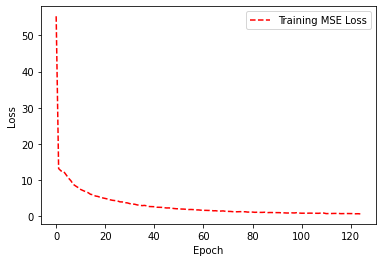

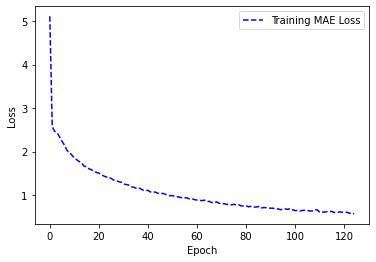

In [12]:
# plotting mse loss
training_mse_loss = model_history.history['loss']
training_mae_loss = model_history.history['mean_absolute_error']

epoch_count = range(0,len(training_mse_loss))

plt.plot(epoch_count, training_mse_loss[0:], 'r--')
plt.legend(['Training MSE Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

plt.plot(epoch_count, training_mae_loss[0:], 'b--')
plt.legend(['Training MAE Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [13]:
# evaluate on test data
yhat = model.predict(padded_test_X)

# evaluate on train data
yhat_train = model.predict(padded_train_X)

584/584 [==============================] - 4s 8ms/step


test metrics
1.1443366009406082
3.2562468936642692
0.9644969460850663
train metrics
0.6044939398805167
0.7141830906446024
0.9921551502002849


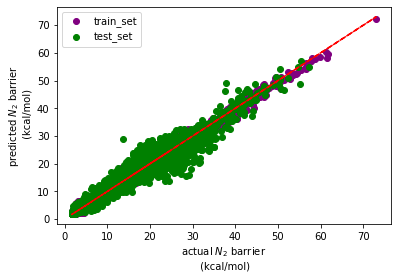

In [14]:
print("test metrics")
mae_test = metrics.mean_absolute_error(test_y,yhat)
mse_test = metrics.mean_squared_error(test_y,yhat)
r2_test = metrics.r2_score(test_y,yhat)

print(mae_test)
print(mse_test)
print(r2_test)

print("train metrics")
mae_train = metrics.mean_absolute_error(train_y,yhat_train)
mse_train = metrics.mean_squared_error(train_y,yhat_train)
r2_train = metrics.r2_score(train_y,yhat_train)

print(mae_train)
print(mse_train)
print(r2_train)

plt.scatter(train_y,yhat_train,color = 'purple')
plt.scatter(test_y,yhat, color = 'green')
plt.plot(train_y,train_y, 'r--')
#plt.title('Parity plot')
plt.ylabel('predicted $N_{2}$ barrier \n (kcal/mol)')
plt.xlabel('actual $N_{2}$ barrier \n (kcal/mol)')
plt.legend(['train_set', 'test_set'])
plt.show()

# Saving the trained model

In [16]:
from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model

In [17]:
# save the model to disk
filename = 'output/N2_barrier_stablestrong/N2_barrier_finalmodel2.h5'
save_model(model, filename)

# loading the saved model

In [18]:
# load the model from disk
filename = 'output/N2_barrier_stablestrong/N2_barrier_finalmodel2.h5'
loaded_model = load_model(filename)

# testing the saved model

In [19]:
# evaluate on train and test data
yhat_test_loaded = loaded_model.predict(padded_test_X)
yhat_train_loaded = loaded_model.predict(padded_train_X)

584/584 [==============================] - 5s 8ms/step


In [20]:
print("test metrics")
mae_test = metrics.mean_absolute_error(test_y,yhat_test_loaded)
mse_test = metrics.mean_squared_error(test_y,yhat_test_loaded)
r2_test = metrics.r2_score(test_y,yhat_test_loaded)

print(mae_test)
print(mse_test)
print(r2_test)

print("train metrics")
mae_train = metrics.mean_absolute_error(train_y,yhat_train_loaded)
mse_train = metrics.mean_squared_error(train_y,yhat_train_loaded)
r2_train = metrics.r2_score(train_y,yhat_train_loaded)

print(mae_train)
print(mse_train)
print(r2_train)

test metrics
1.1783563214777137
3.539484630777188
0.9614087881597475
train metrics
0.6550249371479825
0.8310166955277077
0.9908718069037642


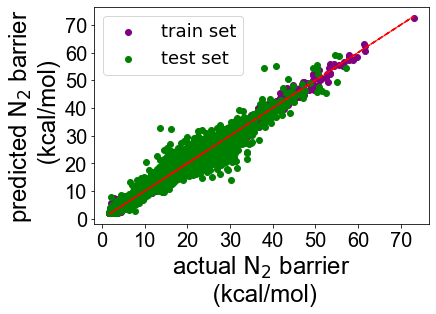

In [21]:
plt.scatter(train_y,yhat_train_loaded,color = 'purple')
plt.scatter(test_y,yhat_test_loaded, color = 'green')
plt.plot(train_y,train_y, 'r--')

plt.ylabel('predicted $\\rm N_{2}$ barrier \n (kcal/mol)', fontname="Arial", fontsize=24)
plt.xlabel('actual $\\rm N_{2}$ barrier \n (kcal/mol)', fontname="Arial", fontsize=24)
plt.legend(['train set', 'test set'], fontsize="18" )
plt.xticks(fontsize=20, fontname="Arial")
plt.yticks(fontsize=20, fontname="Arial")
plt.savefig("figures/N2_barrier_stablestrong/final2_parityplot.png", format="png", dpi=1600, bbox_inches='tight')
plt.show()

# Predicting N2 Barriers for stable nanopores obtained using STRONGs algorithm

In [22]:
# Feature Data - Canonical STRONGs for stable nanopores

csv_data_stable_nanopores = pd.read_csv('input/stable_strongs.csv')
csv_data_stable_nanopores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188180 entries, 0 to 188179
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   pore_number              188180 non-null  int64  
 1   N                        188180 non-null  int64  
 2   STRONG                   188180 non-null  object 
 3   Canonical_STRONG         188180 non-null  object 
 4   x_coord                  188180 non-null  float64
 5   y_coord                  188180 non-null  float64
 6   radius                   188180 non-null  float64
 7   Canonical_STRONG_radius  188180 non-null  object 
dtypes: float64(3), int64(2), object(3)
memory usage: 11.5+ MB


In [23]:
# Tokenization of Feature Data

stable_nanopores_STRONG_X = tokenizer.texts_to_sequences(csv_data_stable_nanopores['Canonical_STRONG_radius'])
stable_nanopores_padded_X = tf.keras.preprocessing.sequence.pad_sequences(stable_nanopores_STRONG_X, padding="post", maxlen = padded_len)

In [24]:
# Calculating N2 barriers for stable nanopores
stable_nanopores_yhat = loaded_model.predict(stable_nanopores_padded_X)

5881/5881 [==============================] - 54s 9ms/step


In [26]:
# saving the N2 barrier for stable nanopores
type(stable_nanopores_yhat)
np.savetxt('output/N2_barrier_stablestrong/stablestrong_barrierN2_final2.csv', stable_nanopores_yhat)

# Performace Check

In [58]:
y_train = train_y.to_numpy()
y_train = y_train.reshape(18663,1)
delta_train =  abs(y_train - yhat_train_loaded)

y_test = test_y.to_numpy()
y_test = y_test.reshape(6221,1)
delta_test =  abs(y_test - yhat_test_loaded)


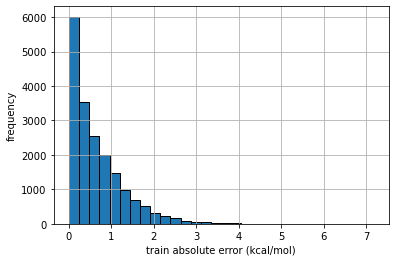

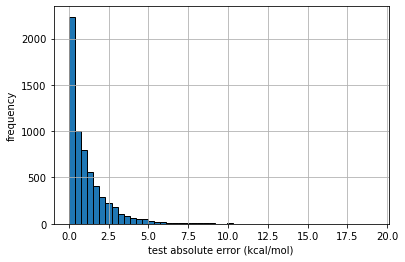

In [60]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(delta_train, bins=30, edgecolor='black')
plt.xlabel('train absolute error (kcal/mol)')
plt.ylabel('frequency')
plt.grid(True)
plt.show()


plt.hist(delta_test, bins=50, edgecolor='black')
plt.xlabel('test absolute error (kcal/mol)')
plt.ylabel('frequency')
plt.grid(True)
plt.show()